(c) 2023 Manuel Razo. This work is licensed under a [Creative Commons
Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/).
All code contained herein is licensed under an [MIT
license](https://opensource.org/licenses/MIT).

In [1]:
# Load project package
@load_pkg BayesFitUtils

import Revise
# Import project package
import BayesFitUtils

# Import package to handle DataFrames
import DataFrames as DF
import CSV
import XLSX

# Import basic statistical functions
import StatsBase

# Import library to list files
import Glob

# Load CairoMakie for plotting
using CairoMakie
import ColorSchemes
import Makie
# Activate backend
CairoMakie.activate!()

# Set PBoC Plotting style
BayesFitUtils.viz.pboc_makie!()

# Data Wrangling for Kinsler et al., 2020

In this notebook we will turn the raw barcode counts from the Kinsler et al.,
2020 eLife paper experiment into a tidy data frame. Let's begin by loading the
raw `.csv` file.

In [42]:
# Load CSV file
df = CSV.read("$(git_root())/data/kinsler_2020/bc_counts.csv", DF.DataFrame)

first(df, 5)

Row,1.4%-R1-T1,1.4%-R1-T2,1.4%-R1-T3,1.4%-R1-T4,1.4%-R2-T1,1.4%-R2-T2,1.4%-R2-T3,1.4%-R2-T4,1.4%-T0,1.5%-R1-T1,1.5%-R1-T2,1.5%-R1-T3,1.5%-R1-T4,1.5%-R2-T1,1.5%-R2-T2,1.5%-R2-T3,1.5%-R2-T4,1.5%-T0,1.6%-R1-T1,1.6%-R1-T2,1.6%-R1-T3,1.6%-R1-T4,1.6%-R2-T1,1.6%-R2-T2,1.6%-R2-T3,1.6%-R2-T4,1.6%-T0,1.7%-R1-T1,1.7%-R1-T2,1.7%-R1-T3,1.7%-R1-T4,1.7%-R2-T1,1.7%-R2-T2,1.7%-R2-T3,1.7%-R2-T4,1.7%-T0,1.8%-R1-T1,1.8%-R1-T2,1.8%-R1-T3,1.8%-R1-T4,1.8%-R2-T1,1.8%-R2-T2,1.8%-R2-T3,1.8%-R2-T4,1.8%-T0,13-0,13-0_pool,13-1-1,13-1-2,13-1-3,13-2-1,13-2-2,13-2-3,13-3-1,13-3-2,13-3-3,13-4-1,13-4-2,13-4-3,18-1-1,18-1-2,18-1-3,18-2-1,18-2-2,18-2-3,18-3-1,18-3-2,18-3-3,18-4-1,18-4-2,18-4-3,2.5%-R1-T1,2.5%-R1-T2,2.5%-R1-T3,2.5%-R1-T4,2.5%-R2-T1,2.5%-R2-T2,2.5%-R2-T3,2.5%-R2-T4,2.5%-T0,20-1-1,20-1-2,20-1-3,20-2-1,20-2-2,20-2-3,20-3-1,20-3-2,20-3-3,20-4-1,20-4-2,20-4-3,21+wt,21-0-1,21-0-2,21-0-4,21-1-1,21-1-2,21-1-3,21-2-1,⋯
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,⋯
1,174.0,109.0,85.0,68.0,3.0,91.0,56.0,42.0,22.0,74.0,85.0,64.0,70.0,66.0,69.0,66.0,68.0,51.0,121.0,113.0,120.0,245.0,102.0,212.0,146.0,116.0,56.0,130.0,227.0,122.0,109.0,108.0,141.0,85.0,142.0,95.0,102.0,181.0,184.0,216.0,176.0,239.0,45.0,42.0,69.0,2.0,10.0,512.0,700.0,594.0,594.0,403.0,104.0,319.0,299.0,361.0,51.0,70.0,59.0,90.0,133.0,122.0,40.0,65.0,481.0,365.0,102.0,574.0,486.0,516.0,380.0,27.0,19.0,17.0,24.0,10.0,11.0,7.0,6.0,20.0,773.0,2336.0,2192.0,2785.0,2493.0,2199.0,1855.0,1569.0,1775.0,954.0,1495.0,1990.0,0.0,3276.0,3105.0,3372.0,962.0,760.0,1889.0,1883.0,⋯
2,7374.0,18479.0,44673.0,96279.0,104.0,13081.0,26243.0,50295.0,629.0,2713.0,8975.0,19736.0,63889.0,2161.0,8175.0,19028.0,50199.0,1102.0,5096.0,13055.0,30405.0,141123.0,3330.0,17235.0,32195.0,65247.0,975.0,3784.0,15314.0,33243.0,34457.0,3473.0,8792.0,13059.0,80332.0,1314.0,3447.0,13525.0,32522.0,97939.0,6641.0,18834.0,7138.0,19516.0,1379.0,2625.0,3914.0,43106.0,54385.0,42068.0,160273.0,107883.0,20536.0,399304.0,308884.0,267212.0,223043.0,241795.0,145296.0,22844.0,14132.0,7847.0,6260.0,14745.0,66171.0,179028.0,49741.0,171156.0,491772.0,661420.0,367527.0,1017.0,810.0,1284.0,4544.0,211.0,612.0,670.0,2104.0,328.0,5215.0,14656.0,12802.0,26566.0,24995.0,21013.0,35823.0,31769.0,25010.0,34463.0,49171.0,41128.0,0.0,23186.0,22200.0,22599.0,14470.0,11899.0,27178.0,50457.0,⋯
3,461.0,256.0,200.0,152.0,3.0,271.0,117.0,65.0,118.0,196.0,177.0,122.0,112.0,140.0,203.0,131.0,119.0,165.0,421.0,267.0,254.0,419.0,261.0,508.0,288.0,236.0,160.0,330.0,460.0,227.0,243.0,325.0,278.0,137.0,336.0,302.0,286.0,423.0,425.0,426.0,471.0,549.0,69.0,97.0,268.0,15.0,46.0,2909.0,2977.0,2776.0,2582.0,1640.0,442.0,1524.0,1028.0,1036.0,195.0,161.0,209.0,466.0,681.0,613.0,149.0,331.0,2356.0,1429.0,417.0,2165.0,1460.0,1711.0,1312.0,109.0,36.0,41.0,74.0,26.0,42.0,24.0,33.0,72.0,562.0,2189.0,2077.0,2223.0,2185.0,1772.0,1335.0,1225.0,1724.0,542.0,1056.0,1680.0,0.0,2938.0,2818.0,3181.0,701.0,437.0,1650.0,1422.0,⋯
4,4294.0,5325.0,6792.0,7633.0,57.0,4170.0,4132.0,4534.0,525.0,1546.0,2666.0,3129.0,5504.0,1437.0,2785.0,3453.0,5872.0,1019.0,3180.0,4374.0,5983.0,15873.0,2385.0,6422.0,6826.0,8019.0,842.0,2908.0,6319.0,5848.0,6153.0,2618.0,3807.0,3588.0,14075.0,1363.0,2399.0,6302.0,9329.0,17580.0,4586.0,8297.0,2010.0,3422.0,1377.0,710.0,1187.0,3

Let's begin by extracting the name of all non-metadata columns.

In [52]:
# List metadata columns
metadata_col = ["additional_muts", "barcode", "class", "gene", "ploidy", "type"]

# Extract dataset names
cond_names = DF.names(df[:, DF.Not(metadata_col)])

println("Number of column: $(length(cond_names))")

cond_names

Number of column: 340


340-element Vector{String}:
 "1.4%-R1-T1"
 "1.4%-R1-T2"
 "1.4%-R1-T3"
 "1.4%-R1-T4"
 "1.4%-R2-T1"
 "1.4%-R2-T2"
 "1.4%-R2-T3"
 "1.4%-R2-T4"
 "1.4%-T0"
 "1.5%-R1-T1"
 ⋮
 "1%Raf-R1-T1"
 "1%Raf-R1-T2"
 "1%Raf-R1-T3"
 "1%Raf-R1-T4"
 "1%Raf-R2-T0"
 "1%Raf-R2-T1"
 "1%Raf-R2-T2"
 "1%Raf-R2-T3"
 "1%Raf-R2-T4"

Next, let's extract the columns that already have the "right" format. This means
they are of the form `condition-R#-T#` or `condition-T0`. These columns, we can
easily parse when producing a tidy dataframe.

In [44]:
# Extract "correct names
correct_names = cond_names[occursin.("-T", cond_names)]

println("Number of correct columns: $(length(correct_names))")

correct_names

Number of correct columns: 81


81-element Vector{String}:
 "1.4%-R1-T1"
 "1.4%-R1-T2"
 "1.4%-R1-T3"
 "1.4%-R1-T4"
 "1.4%-R2-T1"
 "1.4%-R2-T2"
 "1.4%-R2-T3"
 "1.4%-R2-T4"
 "1.4%-T0"
 "1.5%-R1-T1"
 ⋮
 "Ben2-R1-T1"
 "Ben2-R1-T2"
 "Ben2-R1-T3"
 "Ben2-R1-T4"
 "Ben2-R2-T1"
 "Ben2-R2-T2"
 "Ben2-R2-T3"
 "Ben2-R2-T4"
 "Ben2-T0"

Deducing from the information the authors sent, we can map a few of the other
letter-based names to conditions. This is the list provided by the authors.

In [45]:
# Define the raw list sent by the authors on a Python Jupyter notebook
bigbatch_conditions = Dict(
    "M3" => ["A", "B", "C", "D"],
    "Baffle" => ["E", "F"],
    "1.4%Gluc" => ["G", "H"],
    "1.8%Gluc" => ["I", "J"],
    "0.2MNaCl" => ["K", "L"],
    "0.5MNaCl" => ["M", "N"],
    "0.2MKCl" => ["O"],
    "0.5MKCl" => ["P"],
    "8.5uMGdA" => ["Q", "R"],
    "17uMGdA" => ["S", "T"],
    "2ugFlu" => ["U", "V"],
    "0.5ugFlu" => ["W", "X"],
    "1%Raf" => ["Y", "Z"],
    "0.5%Raf" => ["AA", "BB"],
    "1%Gly" => ["CC", "DD"],
    "1%EtOH" => ["EE", "FF"],
    "SucRaf" => ["GG"],
)

Dict{String, Vector{String}} with 17 entries:
  "1%EtOH"   => ["EE", "FF"]
  "0.5ugFlu" => ["W", "X"]
  "M3"       => ["A", "B", "C", "D"]
  "0.5%Raf"  => ["AA", "BB"]
  "8.5uMGdA" => ["Q", "R"]
  "0.2MKCl"  => ["O"]
  "1%Gly"    => ["CC", "DD"]
  "1%Raf"    => ["Y", "Z"]
  "1.4%Gluc" => ["G", "H"]
  "Baffle"   => ["E", "F"]
  "0.5MNaCl" => ["M", "N"]
  "0.5MKCl"  => ["P"]
  "17uMGdA"  => ["S", "T"]
  "1.8%Gluc" => ["I", "J"]
  "SucRaf"   => ["GG"]
  "0.2MNaCl" => ["K", "L"]
  "2ugFlu"   => ["U", "V"]

Let's invert the dictionary to have the letters map to a condition and a replica
number

In [46]:
# Initialize dictionary to save conditions
cond_dict = Dict()

# Loop through given conditions
for (key, item) in bigbatch_conditions
    # Merge dictionaries where each name gets a condition and a replica number
    merge!(
        cond_dict,
        Dict(["$(item[i])" => "$(key)-R$(i)" for i = 1:length(item)])
    )
end # for

cond_dict

Dict{Any, Any} with 33 entries:
  "Z"  => "1%Raf-R2"
  "Q"  => "8.5uMGdA-R1"
  "FF" => "1%EtOH-R2"
  "W"  => "0.5ugFlu-R1"
  "T"  => "17uMGdA-R2"
  "C"  => "M3-R3"
  "P"  => "0.5MKCl-R1"
  "K"  => "0.2MNaCl-R1"
  "V"  => "2ugFlu-R2"
  "CC" => "1%Gly-R1"
  "L"  => "0.2MNaCl-R2"
  "O"  => "0.2MKCl-R1"
  "BB" => "0.5%Raf-R2"
  "B"  => "M3-R2"
  "M"  => "0.5MNaCl-R1"
  "N"  => "0.5MNaCl-R2"
  "GG" => "SucRaf-R1"
  "H"  => "1.4%Gluc-R2"
  "A"  => "M3-R1"
  ⋮    => ⋮

The column names on the dataframe that match to either of these conditions must
have either two characters--a letter and a number specifying the time point--or
three characters--two letters and a number specifying the character--and start
with a letter. Let's extract those column names by these features.

In [47]:
# Extract column names by length and begining with string.
# NOTE: ^\D searches patterns whose first character is NOT a digit
len_names = cond_names[
    (length.(cond_names).≤3).&(match.(r"^\D", cond_names).!==nothing)
]

165-element Vector{String}:
 "A0"
 "A1"
 "A2"
 "A3"
 "A4"
 "AA0"
 "AA1"
 "AA2"
 "AA3"
 "AA4"
 ⋮
 "Y1"
 "Y2"
 "Y3"
 "Y4"
 "Z0"
 "Z1"
 "Z2"
 "Z3"
 "Z4"

Let's loop through these names and generate the corresponding "correct"
condition name.

In [48]:
# Initialize dictionary where to save correct names
letter_names_dict = Dict{String,String}()

# Loop through columns that satisfied condition
for i in len_names
    letter_names_dict[i] = "$(cond_dict[i[1:end-1]])-T$(i[end])"
end # for

letter_names_dict

Dict{String, String} with 165 entries:
  "O1"  => "0.2MKCl-R1-T1"
  "R2"  => "8.5uMGdA-R2-T2"
  "X1"  => "0.5ugFlu-R2-T1"
  "V3"  => "2ugFlu-R2-T3"
  "G4"  => "1.4%Gluc-R1-T4"
  "I4"  => "1.8%Gluc-R1-T4"
  "O4"  => "0.2MKCl-R1-T4"
  "BB3" => "0.5%Raf-R2-T3"
  "BB2" => "0.5%Raf-R2-T2"
  "N0"  => "0.5MNaCl-R2-T0"
  "U4"  => "2ugFlu-R1-T4"
  "T4"  => "17uMGdA-R2-T4"
  "CC4" => "1%Gly-R1-T4"
  "V1"  => "2ugFlu-R2-T1"
  "S4"  => "17uMGdA-R1-T4"
  "U2"  => "2ugFlu-R1-T2"
  "DD2" => "1%Gly-R2-T2"
  "G2"  => "1.4%Gluc-R1-T2"
  "Y0"  => "1%Raf-R1-T0"
  ⋮     => ⋮

We can now use this dictionary to rename the columns of the original dataframe.

In [49]:
# Rename dataframe columns
DF.rename!(df, letter_names_dict)

first(df, 5)

Row,1.4%-R1-T1,1.4%-R1-T2,1.4%-R1-T3,1.4%-R1-T4,1.4%-R2-T1,1.4%-R2-T2,1.4%-R2-T3,1.4%-R2-T4,1.4%-T0,1.5%-R1-T1,1.5%-R1-T2,1.5%-R1-T3,1.5%-R1-T4,1.5%-R2-T1,1.5%-R2-T2,1.5%-R2-T3,1.5%-R2-T4,1.5%-T0,1.6%-R1-T1,1.6%-R1-T2,1.6%-R1-T3,1.6%-R1-T4,1.6%-R2-T1,1.6%-R2-T2,1.6%-R2-T3,1.6%-R2-T4,1.6%-T0,1.7%-R1-T1,1.7%-R1-T2,1.7%-R1-T3,1.7%-R1-T4,1.7%-R2-T1,1.7%-R2-T2,1.7%-R2-T3,1.7%-R2-T4,1.7%-T0,1.8%-R1-T1,1.8%-R1-T2,1.8%-R1-T3,1.8%-R1-T4,1.8%-R2-T1,1.8%-R2-T2,1.8%-R2-T3,1.8%-R2-T4,1.8%-T0,13-0,13-0_pool,13-1-1,13-1-2,13-1-3,13-2-1,13-2-2,13-2-3,13-3-1,13-3-2,13-3-3,13-4-1,13-4-2,13-4-3,18-1-1,18-1-2,18-1-3,18-2-1,18-2-2,18-2-3,18-3-1,18-3-2,18-3-3,18-4-1,18-4-2,18-4-3,2.5%-R1-T1,2.5%-R1-T2,2.5%-R1-T3,2.5%-R1-T4,2.5%-R2-T1,2.5%-R2-T2,2.5%-R2-T3,2.5%-R2-T4,2.5%-T0,20-1-1,20-1-2,20-1-3,20-2-1,20-2-2,20-2-3,20-3-1,20-3-2,20-3-3,20-4-1,20-4-2,20-4-3,21+wt,21-0-1,21-0-2,21-0-4,21-1-1,21-1-2,21-1-3,21-2-1,⋯
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,⋯
1,174.0,109.0,85.0,68.0,3.0,91.0,56.0,42.0,22.0,74.0,85.0,64.0,70.0,66.0,69.0,66.0,68.0,51.0,121.0,113.0,120.0,245.0,102.0,212.0,146.0,116.0,56.0,130.0,227.0,122.0,109.0,108.0,141.0,85.0,142.0,95.0,102.0,181.0,184.0,216.0,176.0,239.0,45.0,42.0,69.0,2.0,10.0,512.0,700.0,594.0,594.0,403.0,104.0,319.0,299.0,361.0,51.0,70.0,59.0,90.0,133.0,122.0,40.0,65.0,481.0,365.0,102.0,574.0,486.0,516.0,380.0,27.0,19.0,17.0,24.0,10.0,11.0,7.0,6.0,20.0,773.0,2336.0,2192.0,2785.0,2493.0,2199.0,1855.0,1569.0,1775.0,954.0,1495.0,1990.0,0.0,3276.0,3105.0,3372.0,962.0,760.0,1889.0,1883.0,⋯
2,7374.0,18479.0,44673.0,96279.0,104.0,13081.0,26243.0,50295.0,629.0,2713.0,8975.0,19736.0,63889.0,2161.0,8175.0,19028.0,50199.0,1102.0,5096.0,13055.0,30405.0,141123.0,3330.0,17235.0,32195.0,65247.0,975.0,3784.0,15314.0,33243.0,34457.0,3473.0,8792.0,13059.0,80332.0,1314.0,3447.0,13525.0,32522.0,97939.0,6641.0,18834.0,7138.0,19516.0,1379.0,2625.0,3914.0,43106.0,54385.0,42068.0,160273.0,107883.0,20536.0,399304.0,308884.0,267212.0,223043.0,241795.0,145296.0,22844.0,14132.0,7847.0,6260.0,14745.0,66171.0,179028.0,49741.0,171156.0,491772.0,661420.0,367527.0,1017.0,810.0,1284.0,4544.0,211.0,612.0,670.0,2104.0,328.0,5215.0,14656.0,12802.0,26566.0,24995.0,21013.0,35823.0,31769.0,25010.0,34463.0,49171.0,41128.0,0.0,23186.0,22200.0,22599.0,14470.0,11899.0,27178.0,50457.0,⋯
3,461.0,256.0,200.0,152.0,3.0,271.0,117.0,65.0,118.0,196.0,177.0,122.0,112.0,140.0,203.0,131.0,119.0,165.0,421.0,267.0,254.0,419.0,261.0,508.0,288.0,236.0,160.0,330.0,460.0,227.0,243.0,325.0,278.0,137.0,336.0,302.0,286.0,423.0,425.0,426.0,471.0,549.0,69.0,97.0,268.0,15.0,46.0,2909.0,2977.0,2776.0,2582.0,1640.0,442.0,1524.0,1028.0,1036.0,195.0,161.0,209.0,466.0,681.0,613.0,149.0,331.0,2356.0,1429.0,417.0,2165.0,1460.0,1711.0,1312.0,109.0,36.0,41.0,74.0,26.0,42.0,24.0,33.0,72.0,562.0,2189.0,2077.0,2223.0,2185.0,1772.0,1335.0,1225.0,1724.0,542.0,1056.0,1680.0,0.0,2938.0,2818.0,3181.0,701.0,437.0,1650.0,1422.0,⋯
4,4294.0,5325.0,6792.0,7633.0,57.0,4170.0,4132.0,4534.0,525.0,1546.0,2666.0,3129.0,5504.0,1437.0,2785.0,3453.0,5872.0,1019.0,3180.0,4374.0,5983.0,15873.0,2385.0,6422.0,6826.0,8019.0,842.0,2908.0,6319.0,5848.0,6153.0,2618.0,3807.0,3588.0,14075.0,1363.0,2399.0,6302.0,9329.0,17580.0,4586.0,8297.0,2010.0,3422.0,1377.0,710.0,1187.0,3

Again, let's search for the "correct columns" and count them.

In [51]:
# Extract dataset names
cond_names = DF.names(df[:, DF.Not(metadata_col)])

# Extract "correct names
correct_names = cond_names[occursin.("-T", cond_names)]

println("Number of correct columns: $(length(correct_names))")

correct_names

Number of correct columns: 246


246-element Vector{String}:
 "1.4%-R1-T1"
 "1.4%-R1-T2"
 "1.4%-R1-T3"
 "1.4%-R1-T4"
 "1.4%-R2-T1"
 "1.4%-R2-T2"
 "1.4%-R2-T3"
 "1.4%-R2-T4"
 "1.4%-T0"
 "1.5%-R1-T1"
 ⋮
 "1%Raf-R1-T1"
 "1%Raf-R1-T2"
 "1%Raf-R1-T3"
 "1%Raf-R1-T4"
 "1%Raf-R2-T0"
 "1%Raf-R2-T1"
 "1%Raf-R2-T2"
 "1%Raf-R2-T3"
 "1%Raf-R2-T4"

We went from 81/340 to 246/340 correctly named columns! We still have 94 left to
fix though. But, for now, without any further input from the authors, we will
limit ourselves to these columns. Let's convert the "correct" columns into a
tidy dataframe. Furthermore, we will convert the column `count` to `Int64`.

In [74]:
# Filter correct columns + metadata
df_filt = df[:, [correct_names; metadata_col]]

# Transform to tidy dataframe
df_tidy = DF.stack(df_filt, correct_names)

# Add count column with integer counts and remove float column
DF.select!(
    DF.insertcols!(df_tidy, :count => Int64.(df_tidy.value)), DF.Not(:value)
)

# Rename columns
DF.rename!(df_tidy, Dict(:variable => :name))

first(df_tidy[:, DF.Not("additional_muts")], 5)

Row,barcode,class,gene,ploidy,type,name,count
,Int64,String31,String31,String15,String31,String,Int64
1,53,Diploid,Diploid,Diploid,Diploid,1.4%-R1-T1,174
2,151,PKA,IRA1,Haploid,stop_gained,1.4%-R1-T1,7374
3,262,NotSequenced,NotSequenced,NotSequenced,NotSequenced,1.4%-R1-T1,461
4,273,PKA,IRA1,Haploid,frameshift_variant,1.4%-R1-T1,4294
5,323,NotSequenced,NotSequenced,NotSequenced,NotSequenced,1.4%-R1-T1,2827


Next, let's loop through the information contained in the `name` column and add
it to the dataframe. Furthermore, we will add a column `neutral` with booleans
indicating whether the barcode belongs to a neutral lineage. This information is
stored in the `class` column as `ExpNeutral`.

In [75]:
# Extract time point. \w is the regular expression to look for digits.
timepoint = [string(match.(r"T\w", n).match) for n in df_tidy.name]
# Extract time as a number
time = [parse(Int64, x[2:end]) for x in timepoint]

# Extract Replicate number. \w is the regular expression to look for digits.
rep_match = match.(r"-R\w-", df_tidy.name)
# Initialize array to save replicate
rep = Vector{String}(undef, length(df_tidy.name))
# Loop through results
for i = 1:length(rep_match)
    if rep_match[i] == nothing
        rep[i] = "R0"
    else
        rep[i] = replace(rep_match[i].match, "-" => "")
    end # if
end # for

# Extract hub environment
env = String.([split(n, "-")[1] for n in df_tidy.name])

# Search for neutral lineages
neutral = df_tidy.class .== "ExpNeutral"

# Add new columns
DF.insertcols!(
    df_tidy,
    (
        [:rep, :timepoint, :time, :env, :neutral] .=>
            [rep, timepoint, time, env, neutral]
    )...
)

first(df_tidy[:, DF.Not("additional_muts")], 5)

Row,barcode,class,gene,ploidy,type,name,count,rep,timepoint,time,env,neutral
,Int64,String31,String31,String15,String31,String,Int64,String,String,Int64,String,Bool
1,53,Diploid,Diploid,Diploid,Diploid,1.4%-R1-T1,174,R1,T1,1,1.4%,false
2,151,PKA,IRA1,Haploid,stop_gained,1.4%-R1-T1,7374,R1,T1,1,1.4%,false
3,262,NotSequenced,NotSequenced,NotSequenced,NotSequenced,1.4%-R1-T1,461,R1,T1,1,1.4%,false
4,273,PKA,IRA1,Haploid,frameshift_variant,1.4%-R1-T1,4294,R1,T1,1,1.4%,false
5,323,NotSequenced,NotSequenced,NotSequenced,NotSequenced,1.4%-R1-T1,2827,R1,T1,1,1.4%,false


This is already a very useful format. But we can make it more convenient by
turning the `T0` variables into something we can `groupby` with the rest of the
data. Since these initial measurements are shared

In [77]:
first(df_tidy[df_tidy.timepoint.=="T0", 2:end], 5)

Row,barcode,class,gene,ploidy,type,name,count,rep,timepoint,time,env,neutral
,Int64,String31,String31,String15,String31,String,Int64,String,String,Int64,String,Bool
1,53,Diploid,Diploid,Diploid,Diploid,1.4%-T0,22,R0,T0,0,1.4%,false
2,151,PKA,IRA1,Haploid,stop_gained,1.4%-T0,629,R0,T0,0,1.4%,false
3,262,NotSequenced,NotSequenced,NotSequenced,NotSequenced,1.4%-T0,118,R0,T0,0,1.4%,false
4,273,PKA,IRA1,Haploid,frameshift_variant,1.4%-T0,525,R0,T0,0,1.4%,false
5,323,NotSequenced,NotSequenced,NotSequenced,NotSequenced,1.4%-T0,357,R0,T0,0,1.4%,false


In [80]:
# Extract time zero data
df_zero = df_tidy[df_tidy.timepoint.=="T0", :]

# Remove time zero data
df_notzero = df_tidy[df_tidy.timepoint.!="T0", :]

# Initialize new dataframe where to append formatted data
df_tidy_rep = DF.DataFrame()

# Group non-T0 data by rep and env
df_group = DF.groupby(df_notzero, [:rep, :env])

# Extract keys
par_group = keys(df_group)
# Loop through groups
for (i, data) in enumerate(df_group)
    # Collect keys
    par = collect(par_group[i])

    # Extract T0 corresponding data
    data_zero = deepcopy(df_zero[df_zero.env.==par[2], :])

    # Modify values to match format
    data_zero[:, :rep] .= par[1]

    # Append to dataframe
    DF.append!(df_tidy_rep, DF.append!(deepcopy(data_zero), data))
end # for

first(df_tidy_rep[:, 2:end], 5)

Row,barcode,class,gene,ploidy,type,name,count,rep,timepoint,time,env,neutral
,Int64,String31,String31,String15,String31,String,Int64,String,String,Int64,String,Bool
1,53,Diploid,Diploid,Diploid,Diploid,1.4%-T0,22,R1,T0,0,1.4%,false
2,151,PKA,IRA1,Haploid,stop_gained,1.4%-T0,629,R1,T0,0,1.4%,false
3,262,NotSequenced,NotSequenced,NotSequenced,NotSequenced,1.4%-T0,118,R1,T0,0,1.4%,false
4,273,PKA,IRA1,Haploid,frameshift_variant,1.4%-T0,525,R1,T0,0,1.4%,false
5,323,NotSequenced,NotSequenced,NotSequenced,NotSequenced,1.4%-T0,357,R1,T0,0,1.4%,false


To make calculations simpler, let's add columns with the total number of reads
per experiment and the naive frequency estimate for each barcode.

In [85]:
# Use the split-apply-combine strategy to compute total counts for each
# experiment.
count_sum = DF.combine(
    DF.groupby(df_tidy_rep, [:env, :timepoint, :rep]),
    :count => sum
)
# Add count sum to dataframe
DF.leftjoin!(
    df_tidy_rep, count_sum, on=[:env, :timepoint, :rep]
)

# Add naive frequency estimate
df_tidy_rep[!, :freq] = df_tidy_rep.count ./ df_tidy_rep.count_sum

first(df_tidy_rep[:, 2:end], 5)

Row,barcode,class,gene,ploidy,type,name,count,rep,timepoint,time,env,neutral,count_sum,freq
,Int64,String31,String31,String15,String31,String,Int64,String,String,Int64,String,Bool,Int64?,Float64
1,53,Diploid,Diploid,Diploid,Diploid,1.4%-T0,22,R1,T0,0,1.4%,false,65807,0.000334311
2,151,PKA,IRA1,Haploid,stop_gained,1.4%-T0,629,R1,T0,0,1.4%,false,65807,0.00955825
3,262,NotSequenced,NotSequenced,NotSequenced,NotSequenced,1.4%-T0,118,R1,T0,0,1.4%,false,65807,0.00179312
4,273,PKA,IRA1,Haploid,frameshift_variant,1.4%-T0,525,R1,T0,0,1.4%,false,65807,0.00797787
5,323,NotSequenced,NotSequenced,NotSequenced,NotSequenced,1.4%-T0,357,R1,T0,0,1.4%,false,65807,0.00542495


Let's plot the frequency trajectories for one of the experiments.

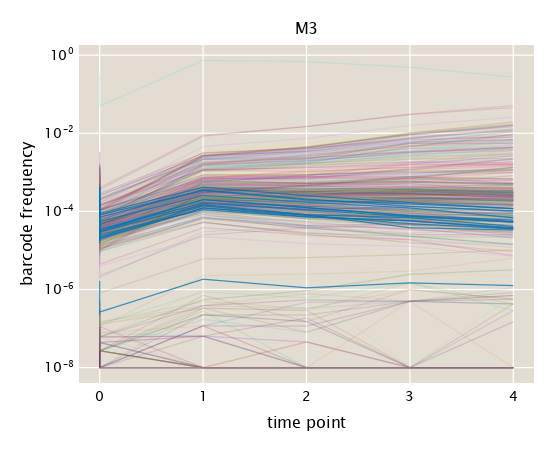

In [95]:
# Define information for data to extract
# Define batch
env = "M3"
rep = "R1"

# Extract data. Note: The time T0 is common to all perturbations, thus, it must
# be extracted separately as a second condition.
data = df_tidy_rep[
    (df_tidy_rep.env.==env).&(df_tidy_rep.rep.==rep),
    :]

# Initialize figure
fig = Figure(resolution=(550, 450))

# Add axis
ax = Axis(
    fig[1, 1],
    xlabel="time point",
    ylabel="barcode frequency",
    yscale=log10,
    title="$(env)"
)

# Define color palette
colors = ColorSchemes.glasbey_hv_n256

# group data by barcode
data_group = DF.groupby(data[.!data.neutral, :], :barcode)
# Loop through trajectories
for bc in data_group
    # Plot trajectory
    lines!(
        bc.time,
        bc.freq .+ 1E-8,
        color=(colors[StatsBase.sample(1:length(colors))], 0.15)
    )
end # for

# group neutral barcodes by barcode
data_group = DF.groupby(data[data.neutral, :], :barcode)
# Loop through trajectories
for bc in data_group
    # Plot trajectory
    lines!(
        bc.time,
        bc.freq .+ 1E-8,
        color=(ColorSchemes.seaborn_colorblind[1], 0.75)
    )
end # for

fig

One more piece of information provided by the authors are the
`condition_categories`. These categories group several conditions into a larger
group such as `glucose`, `salt`, and `drugs`. Here is the list provided by the
authors.

In [101]:
condition_categories = Dict("19" => "M3",
    "M3_Batch_3" => "M3",
    "M3_Batch_6" => "M3",
    "M3_Batch_13" => "M3",
    "M3_Batch_18" => "M3",
    "M3_Batch_20" => "M3",
    "M3_Batch_21" => "M3",
    "M3_Batch_23" => "M3",
    "M3" => "M3", "Baffle" => "glucose",
    "1.4%" => "glucose",
    "1.5%" => "glucose",
    "1.6%" => "glucose",
    "1.7%" => "glucose",
    "1.8%" => "glucose",
    "2.5%" => "glucose",
    "1.4%Gluc" => "glucose",
    "1.8%Gluc" => "glucose", "0.2MNaCl" => "salt",
    "0.5MNaCl" => "salt",
    "0.2MKCl" => "salt",
    "0.5MKCl" => "salt", "8.5uMGdA" => "drugs",
    "17uMGdA" => "drugs",
    "2ugFlu" => "drugs",
    "0.5ugFlu" => "drugs",
    "DMSO" => "drugs",
    "Geldanamycin8.5uM" => "drugs",
    "Ben0.4" => "drugs",
    "Ben2" => "drugs",
    "Ben10" => "drugs", "1%Raf" => "carbons",
    "0.5%Raf" => "carbons",
    "1%Gly" => "carbons",
    "1%EtOH" => "carbons",
    "SucRaf" => "carbons", "Ferm_44hr_Transfer" => "ferm",
    "Ferm_40hr_Transfer" => "ferm",
    "Ferm_54hr_Transfer" => "ferm",
    "Ferm_50hr_Transfer" => "ferm", "Resp_24hr_Transfer" => "resp/stat",
    "Resp_3Day_Transfer" => "resp/stat",
    "Resp_4Day_Transfer" => "resp/stat",
    "Resp_5Day_Transfer" => "resp/stat",
    "Resp_6Day_Transfer" => "resp/stat",
    "Resp_7Day_Transfer" => "resp/stat",
);

Let's map the enviroments to these categories and add a column.

In [103]:
# Add category column
df_tidy_rep[!, :category] = [condition_categories[x] for x in df_tidy_rep.env]

first(df_tidy_rep[:, 2:end], 5)

Row,barcode,class,gene,ploidy,type,name,count,rep,timepoint,time,env,neutral,count_sum,freq,category
,Int64,String31,String31,String15,String31,String,Int64,String,String,Int64,String,Bool,Int64?,Float64,String
1,53,Diploid,Diploid,Diploid,Diploid,1.4%-T0,22,R1,T0,0,1.4%,false,65807,0.000334311,glucose
2,151,PKA,IRA1,Haploid,stop_gained,1.4%-T0,629,R1,T0,0,1.4%,false,65807,0.00955825,glucose
3,262,NotSequenced,NotSequenced,NotSequenced,NotSequenced,1.4%-T0,118,R1,T0,0,1.4%,false,65807,0.00179312,glucose
4,273,PKA,IRA1,Haploid,frameshift_variant,1.4%-T0,525,R1,T0,0,1.4%,false,65807,0.00797787,glucose
5,323,NotSequenced,NotSequenced,NotSequenced,NotSequenced,1.4%-T0,357,R1,T0,0,1.4%,false,65807,0.00542495,glucose


Done! Let's save the dataframe into a `csv` file.

In [104]:
CSV.write("$(git_root())/data/kinsler_2020/tidy_counts.csv", df_tidy_rep)

"/Users/mrazo/git/bayesian_fitness/data/kinsler_2020/tidy_counts.csv"